<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
import seaborn as sns
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

In [3]:
df_iris = sns.load_dataset('iris')
df_iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
X = df_iris.iloc[:,:-1]
y = df_iris.iloc[:,-1]

In [5]:
lgbm = LGBMClassifier()
lgbm.fit(X, y)

LGBMClassifier()

In [6]:
N = 50
my_X = df_iris.iloc[N:N+1,:-1]
lgbm.predict_proba(my_X), df_iris.iloc[N,-1]

(array([[4.28717368e-06, 9.99982856e-01, 1.28568726e-05]]), 'versicolor')

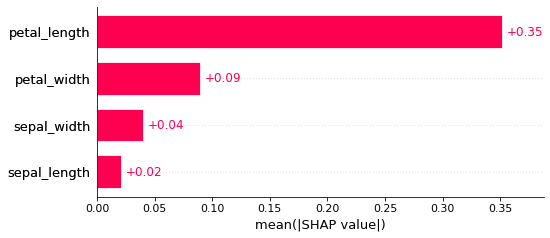

In [9]:
import shap

# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(lgbm.predict_proba, X)
shap_values = explainer(X.iloc[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,0]
shap.plots.bar(shap_values)

In [52]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.rcParams['figure.facecolor']='w'

import catboost
print('catboost version:', catboost.__version__)
from catboost import CatBoostClassifier 
 

catboost version: 0.24.3


In [53]:
titanic_df = pd.read_csv('titanic3.csv')
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [54]:
# strip first letter from cabin number if there
titanic_df['cabin'] = titanic_df['cabin'].replace(np.NaN, 'U') 
titanic_df['cabin'] = [ln[0] for ln in titanic_df['cabin'].values]
titanic_df['cabin'] = titanic_df['cabin'].replace('U', 'Unknown') 
 
# create isfemale field and use numerical values
titanic_df['isfemale'] = np.where(titanic_df['sex'] == 'female', 1, 0)

# drop features not needed for model 
titanic_df = titanic_df[[f for f in list(titanic_df) if f not in ['sex', 'name', 'boat','body', 'ticket', 'home.dest']]]

# make pclass actual categorical column
titanic_df['pclass'] = np.where(titanic_df['pclass'] == 1, 'First', 
                                np.where(titanic_df['pclass'] == 2, 'Second', 'Third'))


titanic_df['embarked'] = titanic_df['embarked'].replace(np.NaN, 'Unknown') 

# impute age to mean
titanic_df['age'] = titanic_df['age'].fillna(titanic_df['age'].mean())
titanic_df['age']

titanic_df['fare'] = titanic_df['fare'].fillna(np.mean(titanic_df['fare']))


titanic_df.head()

,pclass,survived,age,sibsp,parch,fare,cabin,embarked,isfemale
0,First,1,29.00,0,0,211.3375,B,S,1
1,First,1,0.92,1,2,151.5500,C,S,0
2,First,0,2.00,1,2,151.5500,C,S,1
3,First,0,30.00,1,2,151.5500,C,S,0
4,First,0,25.00,1,2,151.5500,C,S,1


In [57]:
from P7_functions import *

In [58]:
ct = CustTransformer(thresh_card=8,
                     strat_binary='ord',
                     strat_low_card='ohe',
                     strat_high_card='loo',
                     strat_quant='stand')

X_train_enc = ct.fit_transform(X_train, y_train)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [59]:
X_train_enc.shape, X_train.shape

((916, 13), (916, 8))

In [60]:
X_train.isna().sum()

pclass      0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
isfemale    0
dtype: int64

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=14)
rf_clf.fit(X_train_enc, y_train['survived'])

RandomForestClassifier(random_state=14)

<AxesSubplot:>

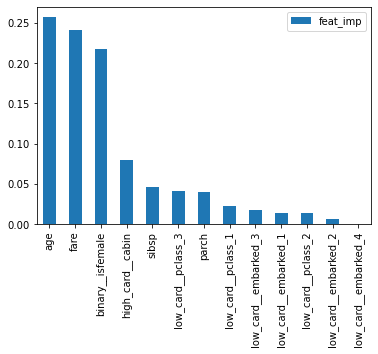

In [72]:
feat_imp_df = pd.DataFrame(rf_clf.feature_importances_,
                           index=X_train_enc.columns,
                          columns= ['feat_imp']).sort_values('feat_imp', ascending=False)
feat_imp_df.plot.bar()

Exact explainer: 101it [13:22,  8.10s/it]                                                                              


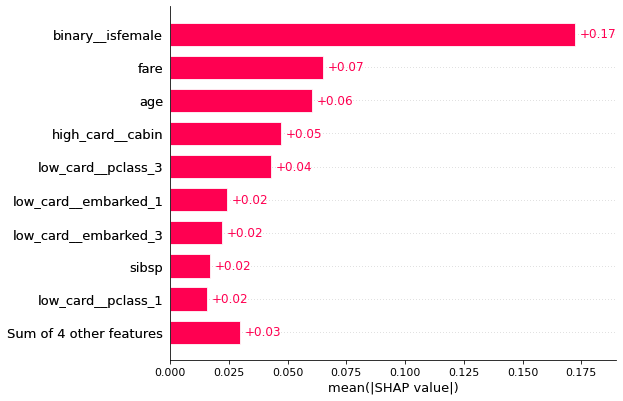

In [73]:
import shap

# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(rf_clf.predict_proba, X_train_enc)
shap_values = explainer(X_train_enc.iloc[:100])
# get just the explanations for the positive class
shap_values = shap_values[...,0]
shap.plots.bar(shap_values)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
rf_clf

In [ ]:
# map categorical features

titanic_catboost_ready_df = titanic_df.dropna() 

features = [feat for feat in list(titanic_catboost_ready_df) 
            if feat != 'survived']
print(features)
categorical_features = np.where(titanic_catboost_ready_df[features].dtypes != np.float)[0]
 

X_train, X_test, y_train, y_test = train_test_split(titanic_df[features], 
                                                    titanic_df[['survived']], 
                                                    test_size=0.3, 
                                                     random_state=1)
 
params = {'iterations':5000,
        'learning_rate':0.01,
        'cat_features':categorical_features,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 1
          }

cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train, y_train,   
          eval_set=(X_test, y_test), 
          use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
          plot=True  
         );

In [22]:
import shap  # package used to calculate Shap values
# SHapley Additive exPlanations
# The goal of SHAP is to explain the prediction of an instance x by computing the contribution of each feature to the prediction. The SHAP explanation method computes Shapley values from coalitional game theory. The feature values of a data instance act as players in a coalition. Shapley values tell us how to fairly distribute the "payout" (= the prediction) among the features. 

from catboost import CatBoostClassifier, Pool

shap_values = cat_model.get_feature_importance(Pool(X_test,
                                                    label=y_test
                                                    cat_features=categorical_features),
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value,
                shap_values[0,:],
                X_test.iloc[0,:])

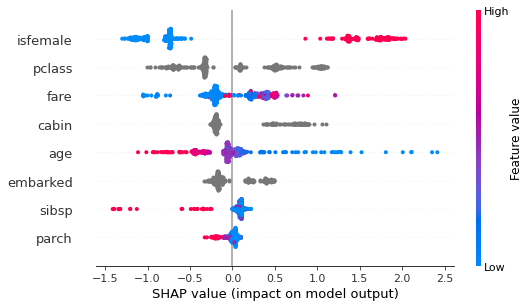

In [25]:
shap.summary_plot(shap_values, X_test)

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFSampleFilter(BaseEstimator, TransformerMixin):

    def __init__(self, contamination=None, n_neighbors=None, **kwargs):
        self.contamination = contamination if contamination is not None else 0.05
        self.n_neighbors = n_neighbors if n_neighbors is not None else 5
        self.kwargs = kwargs

    def fit(self, X, y=None, *args, **kwargs):
        lcf = LocalOutlierFactor(n_neighbors=self.n_neighbors,
                                 contamination=self.contamination,
                                 **self.kwargs)
        samplefilter = pd.Series(lcf.fit_predict(X))
        samplefilter = samplefilter.replace({1: True, # inliners
                                          -1: False}) # outliers
        # computes the filtered dataframe
        self.X_mod = X.loc[samplefilter.values]
        if y is not None:
            self.y_mod = y.loc[samplefilter.values]
        return self

    def transform(self, X, y=None, copy=None):
        if y is not None:
            return self.X_mod, self.y_mod
        else:
            return self.X_mod

    def fit_transform(self, X, y=None, **fit_params):
        if y is None:
            return self.fit(X, **fit_params).transform(X)
        else:
            return self.fit(X, y, **fit_params).transform(X,y)


In [ ]:
# GRIDSEARCHCV

# imbalanced pipeline allowing to resample while cross-validating (resampling only in training folds)

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from lightgbm import LGBMClassifier

pipe = ImbPipeline([
                    ('preproc', CustTransformer(thresh_card=8)), # normalisation and encoding
#                     ('outl_filter', LOFSampleFilter()), # outlier cleaning  IsolForestSampleFilte
                    ('resamp', SMOTE(random_state=14)), # resampling
                    ('clf', LGBMClassifier(random_state=14)) # classification
                   ])

# boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100,
# subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0,
# min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0,
# colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, 

param_grid = {
              'preproc__strat_binary': ['ord'],
              'preproc__strat_low_card': ['ohe'],
              'preproc__strat_high_card': ['loo'],
              'preproc__strat_quant': ['stand'],
#               'resamp__k_neighbors': [5,10],
#               'outl_filter__contamination': [0.05, 0.1],
              'clf__is_unbalance': [True],
              'clf__n_estimators': [50, 100, 200,500],
#               'clf__num_leaves': [10, 20, 30, 400],
#               'clf__reg_alpha': [0, 0.1],
#               'clf__reg_lambda': [0,0.25,0.5],
#               'clf__learning_rate': [1e-2,5e-2,1e-1],
#               'clf__max_depth' :[-1,3],
                    
              }

             
gs = GridSearchCV(estimator = pipe,
                  param_grid = param_grid,
                  scoring = {'f5_scorer': f5_scorer,
                             'precision': precision_scorer,
                             'recall': recall_scorer,
                             'f1': f1_scorer,
                             'roc_auc': roc_auc_scorer,
                             'gain_factor': gain_factor_scorer,
                             'bal_accuracy': balanced_accuracy_scorer,
                             'kappa': kappa_scorer,
                             'mcc': mcc_scorer,
                             'gain': gain_factor_scorer},
                  # 'precision', 'recall', 'f1', 'roc_auc',  ['recall', 'roc_auc']
                  refit='gain',
                  cv=4,
                  verbose=1,
                  return_train_score=True)
                  

In [ ]:
ind_samp = X_train.sample(1000).index

gs.fit(X_train.loc[ind_samp], y_train.loc[ind_samp])

In [ ]:
best_model = gs.best_estimator_
y_tr_pred = best_model.predict(X_tr)
y_te_pred = best_model.predict(X_te)
y_train_pred = best_model.predict(X_train)

gs.best_score_, gs.best_params_

In [ ]:
pd.crosstab(y_tr, y_tr_pred)

In [ ]:
# Computes scores

y_pred_tr = gnb_class.predict(X_tr_enc)
df_res = model_scores(y_tr, y_pred_tr, 'gnb_tr', df_res)

y_pred_te = gnb_class.predict(X_te_enc)
df_res = model_scores(y_te, y_pred_te, 'gnb_te', df_res)

df_res
# computes confusion matrix
cm = pd.crosstab(y_te, y_pred_te)

# to get interactive sankey confusion graph
plot_sankey_confusion_mat(cm, static=False, figsize=(0.2, 0.7),
                          font_size=14, palette=['g', 'r'],
                         title="Gaussian Naive Bayes classifier")

# # to get static sankey confusion graph
# import plotly.graph_objects as go
# from IPython.display import Image

# img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
#                                       figsize=(2, 1.7), scale = 1)
# Image(img_bytes)

In [ ]:
# computes confusion matrix
cm = pd.crosstab(y_te, y_pred_te)

# to get interactive sankey confusion graph
plot_sankey_confusion_mat(cm, static=False, figsize=(0.2, 0.7),
                          font_size=14, palette=['g', 'r'],
                         title="Gaussian Naive Bayes classifier")

# # to get static sankey confusion graph
# import plotly.graph_objects as go
# from IPython.display import Image

# img_bytes = plot_sankey_confusion_mat(cm, static=True, font_size=18,
#                                       figsize=(2, 1.7), scale = 1)
# Image(img_bytes)

In [ ]:
'''
Pipeline standard
'''

###################################

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler

my_cols = ['ORGANIZATION_TYPE', 'CODE_GENDER', 'OCCUPATION_TYPE',
           'DAYS_BIRTH', 'AMT_INCOME_TOTAL', 'TARGET']
X = X_tr.iloc[:100][['CODE_GENDER', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE',
           'DAYS_BIRTH']]
y = X_tr.iloc[:100]['AMT_INCOME_TOTAL'] 
# X.shape, y.shape


pipe = Pipeline([
                 ('preproc', CustTransformer(thresh_card=8)),
	             ('reg', Ridge()) # ('clf', RidgeClassifier()) # classification
                ])


param_grid = {
              'preproc__strat_binary': ['ord'],
              'preproc__strat_low_card': ['ohe', 'ord'],
              'preproc__strat_high_card': ['ord', 'bin'],
              'preproc__strat_quant': ['stand', 'quant_norm'],
              'reg__alpha': np.logspace(-6,-9, 2)
               }

gs = GridSearchCV(estimator = pipe,
                  param_grid = param_grid,
                  scoring=['r2', 'neg_mean_absolute_error'], #['precision', 'recall', 'f1', 'roc_auc'],
                  refit='r2', #'roc_auc',
                  cv=4,
                  verbose=1,
                  return_train_score=True)

gs.fit(X, y)
# pipe.fit_predict(X)
# gs.best_params_

In [ ]:
# # ENCODING

# import warnings
# warnings.filterwarnings('ignore')

# ct = CustTransformer(thresh_card=7,
#                      strat_quant='stand',
#                      strat_binary='ord',
#                      strat_low_card='ohe',
#                      strat_high_card='loo')

# X_tr_enc = ct.fit_transform(X_tr, y_tr) # y_tris here for 'loo'
# X_tr_enc.shape, X_tr_enc.shape

In [ ]:
# # OUTLIER FILTERING

# isolf_filter = IsolForestSampleFilter(contamination=0.05, n_estimators=100)
# isolf_filter.fit_transform(X_tr_enc).shape

# # zsc_filter = ZscoreSampleFilter(thresh=1, keep='any') # on garde les lignes où toutes les colonnes sont inliers
# # lof_filter = LOFSampleFilter(contamination=0.05, n_neighbors=5)
# # isolf_filter = IsolForestSampleFilter(contamination=0.05, n_estimators=100)
# # zsc_filter.fit_transform(X_tr_enc.iloc[:1000]).shape

In [ ]:
# # RESAMPLING

# sm = SMOTE(sampling_strategy='auto', k_neighbors=5,
#           n_jobs=-1, random_state=14) #'minority'

# X_tr_enc_resamp, y_tr_resamp = sm.fit_resample(X_tr_enc, y_tr)

In [ ]:
#     tp = (y_true==y_pred) & (y_true==1) # true positive
#     tn = (y_true==y_pred) & (y_true==0) # true negative
#     fn = (y_true!=y_pred) & (y_true==1) # false negative
#     fp = (y_true!=y_pred) & (y_true==0) # false positive

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('x', -5, 5)
    return (x - 2) ** 2

study = optuna.create_study()
study.optimize(objective, n_trials=100);

study.best_params, study.best_value, len(study.trials)#, study.trials, study.best_trial, 

study.optimize(objective, n_trials=100) # continue optimization
len(study.trials), study.best_params, study.best_value, # updated nb of trials

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.preprocessing import *

class CustTransformer(BaseEstimator) :

    def __init__(self, thresh_card=12,
                 strat_binary = 'ord', strat_low_card ='ohe',
                 strat_high_card ='bin', strat_quant = 'stand'):
        self.thresh_card = thresh_card
        self.strat_binary = strat_binary
        self.strat_low_card = strat_low_card
        self.strat_high_card = strat_high_card
        self.strat_quant = strat_quant

    def d_type_col(self, X):
        bin_cols = (X.nunique()[X.nunique()<=2].index)
        X_C_cols = X.select_dtypes(include=['object', 'category'])
        C_l_card_cols = X_C_cols.nunique()[X_C_cols.nunique().between(3, self.thresh_card)].index
        C_h_card_cols = X_C_cols.nunique()[X_C_cols.nunique()>self.thresh_card].index
        Q_cols = [c for c in X.select_dtypes(include=[np.number]).columns\
                                                        if c not in bin_cols]
        d_t = {'binary': bin_cols,
               'low_card': C_l_card_cols,
               'high_card': C_h_card_cols,
               'numeric': Q_cols}
        return d_t

    def get_feature_names(self):
        return self.ct_cat.get_feature_names()+self.num_cols

    def fit(self, X, y=None):
        # Dictionary to translate strategies
        d_enc = {'ohe': ce.OneHotEncoder(),
                 'hash': ce.HashingEncoder(),
                 'ord': ce.OrdinalEncoder(),
                 'loo': ce.LeaveOneOutEncoder(),
                 'bin': ce.BinaryEncoder(),
                 'stand': StandardScaler(),
                 'minmax': MinMaxScaler(),
                 'maxabs': MaxAbsScaler(),
                 'robust': RobustScaler(quantile_range=(25, 75)),
                 'norm': Normalizer(),
                 'quant_uni': QuantileTransformer(output_distribution='uniform'),
                 'quant_norm': QuantileTransformer(output_distribution='normal'),
                 'boxcox': PowerTransformer(method='boxcox'),
                 'yeo': PowerTransformer(method='yeo-johnson'),
                 'none': FunctionTransformer(func=lambda x:x,
                                             inverse_func=lambda x:x),
                 }

        self.ct_cat = ColumnTransformer([
                                        ('binary', d_enc[self.strat_binary], self.d_type_col(X)['binary']),
                                        ('low_card', d_enc[self.strat_low_card], self.d_type_col(X)['low_card']),
                                        ('high_card', d_enc[self.strat_high_card], self.d_type_col(X)['high_card']),
                                        ],
                                        #remainder='passthrough'
                                        )

        self.num_cols = self.d_type_col(X)['numeric']
        self.num_trans = Pipeline([("numeric", d_enc[self.strat_quant])])

        self.cat_cols = self.d_type_col(X)['binary'].union(self.d_type_col(X)['low_card']).union(self.d_type_col(X)['high_card'])
        self.cat_trans = Pipeline([("categ", self.ct_cat)])

        self.column_trans =  ColumnTransformer([
                                        ('cat', self.cat_trans, self.cat_cols),
                                        ('num', self.num_trans, self.num_cols),
                                        ],
                                        # remainder='passthrough'
                                        )
        self.ct_cat.fit(X, y)
        return self.column_trans.fit(X, y)
  
    def transform(self, X, y=None): # to use in a pipeline
        # return  self.column_trans.transform(X)
        return pd.DataFrame(self.column_trans.transform(X),
                            columns=self.get_feature_names())

    def fit_transform(self, X, y=None):
        # if y is None:
        #     self.fit(X)
        #     return self.column_trans.transform(X)
        # else:
        #     self.fit(X, y)
        #     return self.column_trans.transform(X)
        if y is None:  
            self.fit(X)
            return pd.DataFrame(self.column_trans.transform(X),
                            columns=self.get_feature_names())
        else: 
            self.fit(X, y)
            return pd.DataFrame(self.column_trans.transform(X),
                            columns=self.get_feature_names())
